---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [2]:
import pandas as pd
import numpy as np
import re
from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [3]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [4]:
def get_list_of_university_towns():
    #Returns a DataFrame of towns and the states they are in from the 
    #university_towns.txt list. The format of the DataFrame should be:
    #DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    #columns=["State", "RegionName"]  )
    
    
    with open('university_towns.txt') as utowns:
        #3. Depending on how you read the data, you may need to remove newline character '\n'. 
        data = utowns.read().strip().split('\n')
        utowns.close()
    lst = []
    state = ''
    for row in range(len(data)):
        #1. For "State", removing characters from "[" to the end.
        data[row], chg = re.subn('\[edit\]', '', data[row])
        if chg > 0:
            state = data[row]
            row += 1
        else:
            #2. For "RegionName", when applicable, removing every character from " (" to the end.
            data[row] = re.sub('\(.*', '', data[row]).strip()
            lst.append([state, data[row]])
            
    df = pd.DataFrame(lst)
    df.columns = ['State', 'RegionName']
    
    return df

get_list_of_university_towns().head()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo


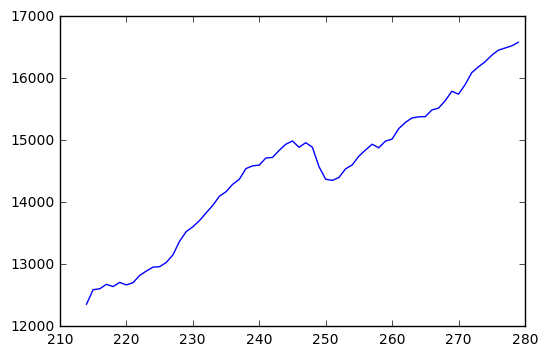

In [5]:
def get_GDP():
    data = pd.read_excel('gdplev.xls', header=4).dropna(axis=1, how='all').dropna(axis=0, how='all')
    data.rename(columns={ 'Unnamed: 4'  : 'Quarterly', 'GDP in billions of chained 2009 dollars.1': 'GDP'}, inplace=True)
    data = data[['Quarterly', 'GDP']]
    data = data[data['Quarterly']>'2000']
    return data
   
    #A recession is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.

%matplotlib inline
import matplotlib.pyplot as pl
g = get_GDP()
pl.plot(g.index, g['GDP'])


In [6]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    #A recession is defined as starting with two consecutive quarters of GDP decline,
    
    GDP = get_GDP()
    for i in range(1,len(GDP)-1):
        if GDP['GDP'].iloc[i-1] > GDP['GDP'].iloc[i] and GDP['GDP'].iloc[i]>GDP['GDP'].iloc[i+1]:
            return GDP['Quarterly'].iloc[i]
    return None    
   
get_recession_start()

'2008q3'

In [7]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    #ending with two consecutive quarters of GDP growth.
    GDP = get_GDP()
    start = get_recession_start()
    GDP = GDP[GDP['Quarterly']>start]
    for i in range(1,len(GDP)-1):
        if GDP['GDP'].iloc[i-1] < GDP['GDP'].iloc[i] and GDP['GDP'].iloc[i]<GDP['GDP'].iloc[i+1]:
            return GDP['Quarterly'].iloc[i+1]
        
get_recession_end()

'2009q4'

In [8]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    #A recession bottom is the quarter within a recession which had the lowest GDP.
    GDP = get_GDP()
    start = get_recession_start()
    end = get_recession_end()
    GDP = GDP[GDP['Quarterly']>start]
    GDP = GDP[GDP['Quarterly']<end] 
    return GDP['Quarterly'].loc[GDP['GDP'].idxmin()]

get_recession_bottom()

'2009q2'

In [9]:
def get_housing_data():
    # Use this dictionary to map state names to two letter acronyms
    states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}
    data = pd.read_csv('City_Zhvi_AllHomes.csv')
    keep = [i for i in data.columns if i > '2000']
    data = data[keep]
    del data['RegionID'], data['Metro'], data['SizeRank'], data['CountyName']
    data.replace({'State': states}, inplace=True)
    return data

get_housing_data().head()

,RegionName,State,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,Los Angeles,California,204400.0,207000.0,209800.0,212300.0,214500.0,216600.0,219000.0,221100.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,Chicago,Illinois,136800.0,138300.0,140100.0,141900.0,143700.0,145300.0,146700.0,147900.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,Philadelphia,Pennsylvania,52700.0,53100.0,53200.0,53400.0,53700.0,53800.0,53800.0,54100.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,Phoenix,Arizona,111000.0,111700.0,112800.0,113700.0,114300.0,115100.0,115600.0,115900.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [10]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    A quarter is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    data = get_housing_data()
    data.set_index(['State', 'RegionName'], inplace=True)
    data.columns = pd.to_datetime(data.columns) #change the column names into datetimeindices
    data = data.resample('Q',axis=1).mean() #changes the columns to be only every quarter and uses the means
    data = data.rename(columns=lambda x: str(x.to_period('Q')).lower()) #converts the datetimes back into strings
    return data
    
convert_housing_data_to_quarters().head()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


In [11]:
def recession_housing_data():
    #creates data showing housing prices decline or growth from recession start to bottom
    #returns only indices and this new column
    housing = convert_housing_data_to_quarters()
    prestart = str(pd.to_datetime(get_recession_start()).to_period('Q')-1).lower()
    housing['change'] = housing[prestart].div(housing[get_recession_bottom()])
    return housing[['change']]

recession_housing_data()

,,change
State,RegionName,
New York,New York,1.081789
California,Los Angeles,1.213498
Illinois,Chicago,1.082840
Pennsylvania,Philadelphia,1.016930
Arizona,Phoenix,1.220131
Nevada,Las Vegas,1.413590
California,San Diego,1.133248
Texas,Dallas,1.097685
California,San Jose,1.153561


In [12]:
def split_housing():
    #breaks housing into university and not
    housing = recession_housing_data()
    uni = get_list_of_university_towns()
    both = pd.merge(uni, housing.reset_index(), on=uni.columns.tolist(), indicator = 'flag', how = 'outer').set_index('RegionName')
    university = both[both['flag']=='both']
    non = both[both['flag']=='right_only']
    return university['change'], non['change']
split_housing()

(RegionName
 Montevallo         0.950479
 Tuscaloosa         1.017770
 Fairbanks          1.127970
 Flagstaff          1.084557
 Tempe              1.125462
 Tucson             1.098763
 Conway             0.996482
 Fayetteville       1.063659
 Arcata             1.113252
 Berkeley           1.067911
 Chico              1.075782
 Claremont          1.097610
 Cotati             1.178497
 Davis              0.973927
 Irvine             1.097770
 Merced             1.408205
 Orange             1.221979
 Palo Alto          1.080125
 Pomona             1.498671
 Redlands           1.108343
 Riverside          1.453341
 Sacramento         1.252753
 San Diego          1.133248
 San Luis Obispo    1.045885
 Santa Barbara      1.108410
 Santa Cruz         1.045023
 Turlock            1.296216
 Whittier           1.201855
 Boulder            1.001500
 Durango            1.057624
                      ...   
 Canyon             0.943013
 College Station    0.964469
 Commerce           0.997994
 D

In [13]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    
    university, non = split_housing()
    stat, p = ttest_ind(university, non, nan_policy='omit')
    different = p<0.01
    better = ['university town' if university.mean()<non.mean() else 'non-university town'][0]
    return different, p, better

run_ttest()
    

(True, 0.0027240637047531249, 'university town')